In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Nadam
from timeit import default_timer as timer 

#### Creo un dataset artificiale normalizzato con un disturbo minimo

In [2]:
n = 2000
test_split_point = 1600
t = np.arange(0, n)
x = (np.sin(0.008 * t) + np.sin(0.03 * t) - np.sin(0.04 * t)) * 6 + (np.random.rand(n) - np.random.rand(n)) / 2

x_min = min(x)
x_max = max(x)

x = (x - x_min) / (x_max - x_min) 

df = pd.DataFrame(x)
df.head()

,0
0,0.472332
1,0.467514
2,0.459592
3,0.474464
4,0.460520


#### Illustrazione del dataset

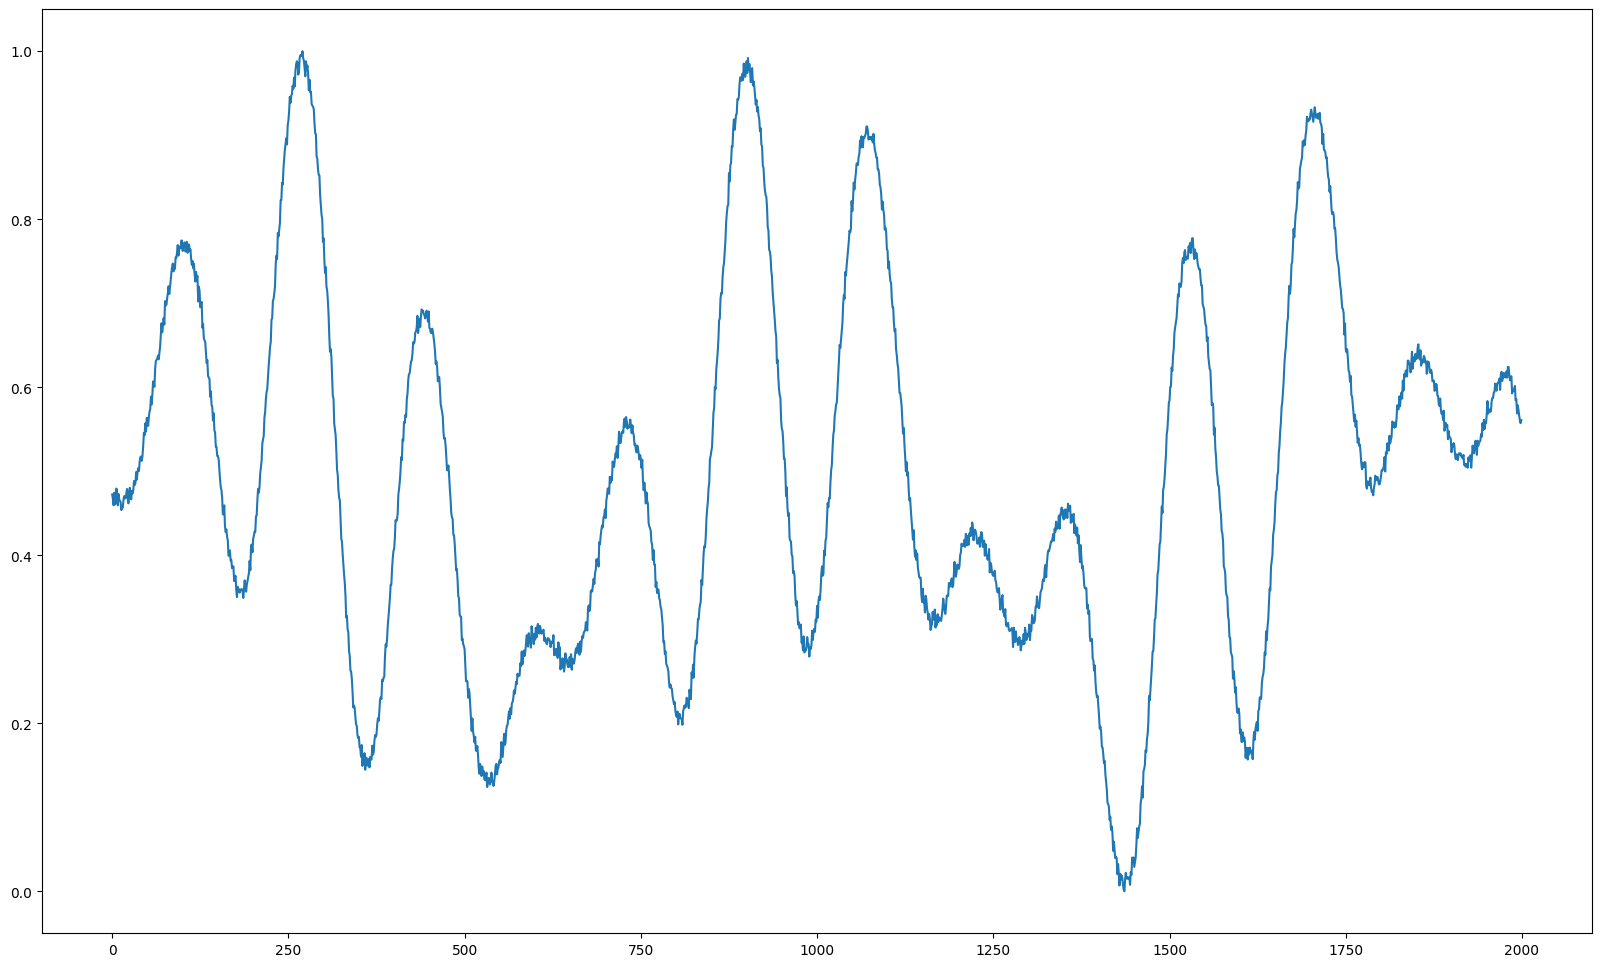

In [3]:
plt.figure(figsize=(20,12))
plt.plot(df)
plt.show()

In [4]:
values = df.values

#### Costruzione delle serie temporali

In [5]:
step = 100

def convert_to_matrix(data, step):
    x, y = [], [] 
    for i in range(len(data) - step):
        d = i + step
        x.append(data[i:d,])
        y.append(data[d,])
    return np.array(x), np.array(y)

train_x, train_y = convert_to_matrix(values[:test_split_point], step)
test_x, test_y = convert_to_matrix(values[test_split_point:], step)

In [6]:
print('Shape addestramento   x', train_x.shape, '   y', train_y.shape)
print('Shape test            x', test_x.shape, '    y', test_y.shape)

Shape addestramento   x (1500, 100, 1)    y (1500, 1)
Shape test            x (300, 100, 1)     y (300, 1)


#### Scrittura architettura e modello Sequenziale RNN 

In [7]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(step, 1), return_sequences= True))
model.add(SimpleRNN(units=64, return_sequences = True))
model.add(SimpleRNN(units=64))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = Nadam(), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 64)           4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23905 (93.38 KB)
Trainable params: 23905 (

#### Addestramento

In [8]:
start = timer()
rnn_h = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
rnn_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 5s - loss: 0.0814 - mean_absolute_error: 0.2226 - 5s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.0246 - mean_absolute_error: 0.1269 - 676ms/epoch - 225ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0113 - mean_absolute_error: 0.0870 - 627ms/epoch - 209ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0072 - mean_absolute_error: 0.0671 - 625ms/epoch - 208ms/step
Epoch 5/10
3/3 - 1s - loss: 0.0045 - mean_absolute_error: 0.0563 - 664ms/epoch - 221ms/step
Epoch 6/10
3/3 - 1s - loss: 0.0028 - mean_absolute_error: 0.0435 - 652ms/epoch - 217ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0028 - mean_absolute_error: 0.0459 - 591ms/epoch - 197ms/step
Epoch 8/10
3/3 - 1s - loss: 0.0021 - mean_absolute_error: 0.0390 - 663ms/epoch - 221ms/step
Epoch 9/10
3/3 - 1s - loss: 0.0014 - mean_absolute_error: 0.0320 - 833ms/epoch - 278ms/step
Epoch 10/10
3/3 - 1s - loss: 7.1300e-04 - mean_absolute_error: 0.0213 - 868ms/epoch - 289ms/step
terminato.


#### Predizioni su tutto il dataset e sul test considerandoli separatamente 

In [9]:
train_predict_rnn = model.predict(train_x)
test_predict_rnn = model.predict(test_x)

10/10 [==============================] - 0s 21ms/step


#### Illustrazione degli output del modello rispetto ai dati reali iniziali

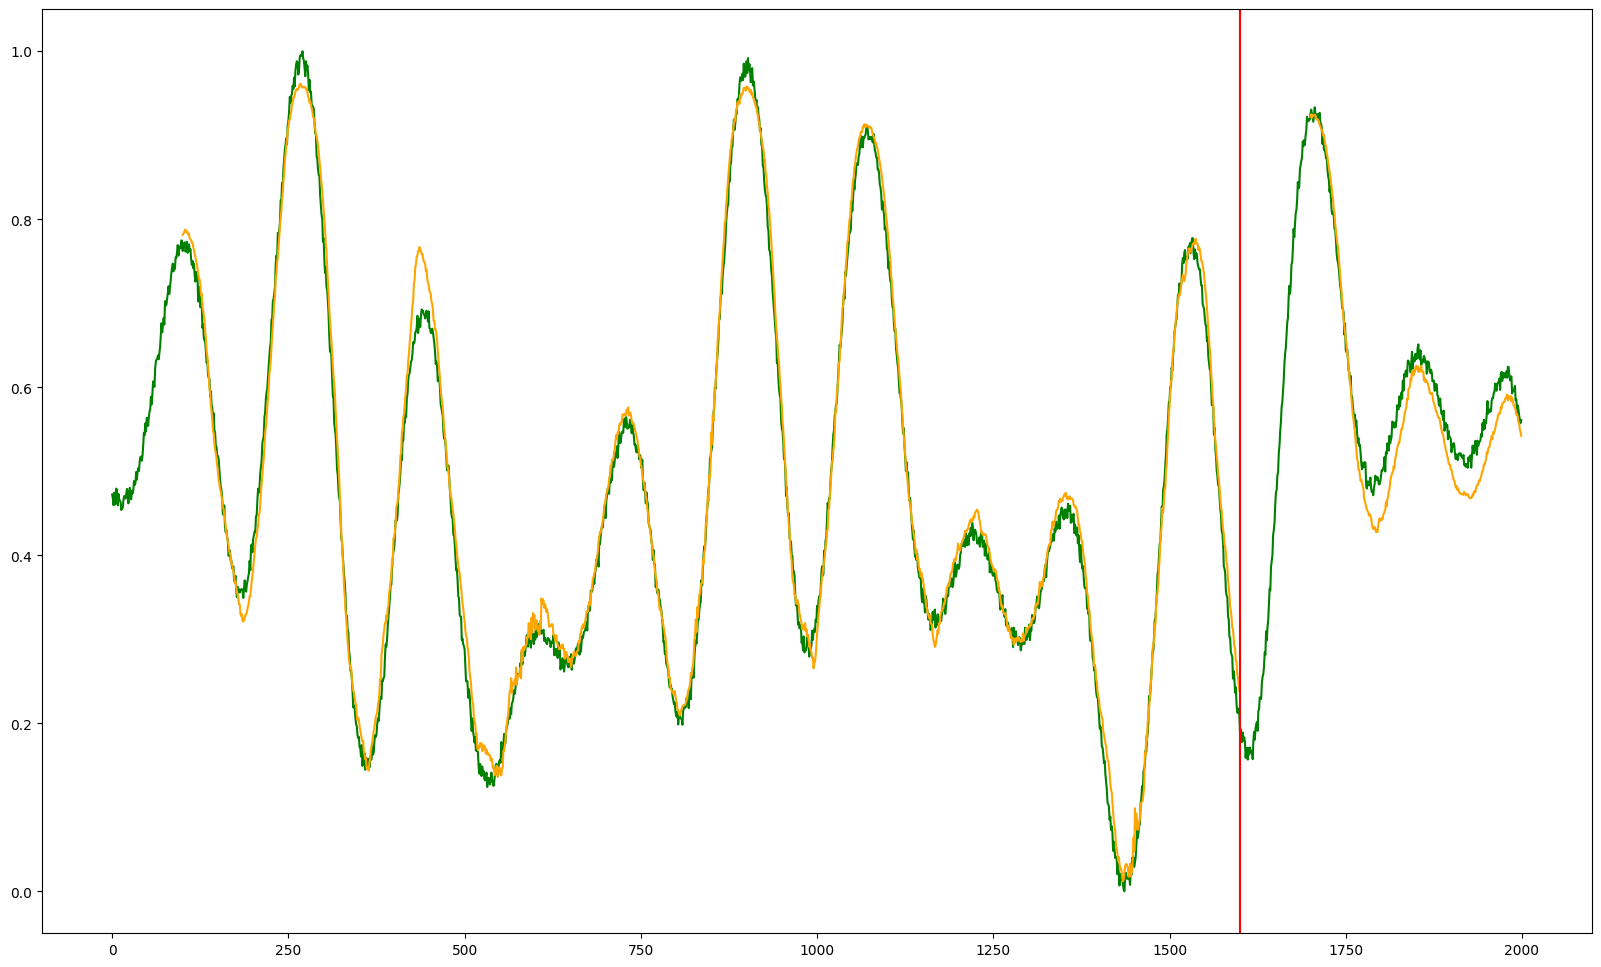

In [10]:
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color = 'green')

x_train_preds = [ x for x in range(step, len(train_predict_rnn) + step)]
plt.plot(x_train_preds, train_predict_rnn, color = 'orange')

x_test_preds = [test_split_point + x +step for x in range(0, len(test_predict_rnn))]
plt.plot (x_test_preds, test_predict_rnn, color = 'orange')

plt.axvline(df.index[test_split_point], c = 'r')
plt.show()

#### Illustrazione predizioni degli ultimi 100 esempi sui dati reali 

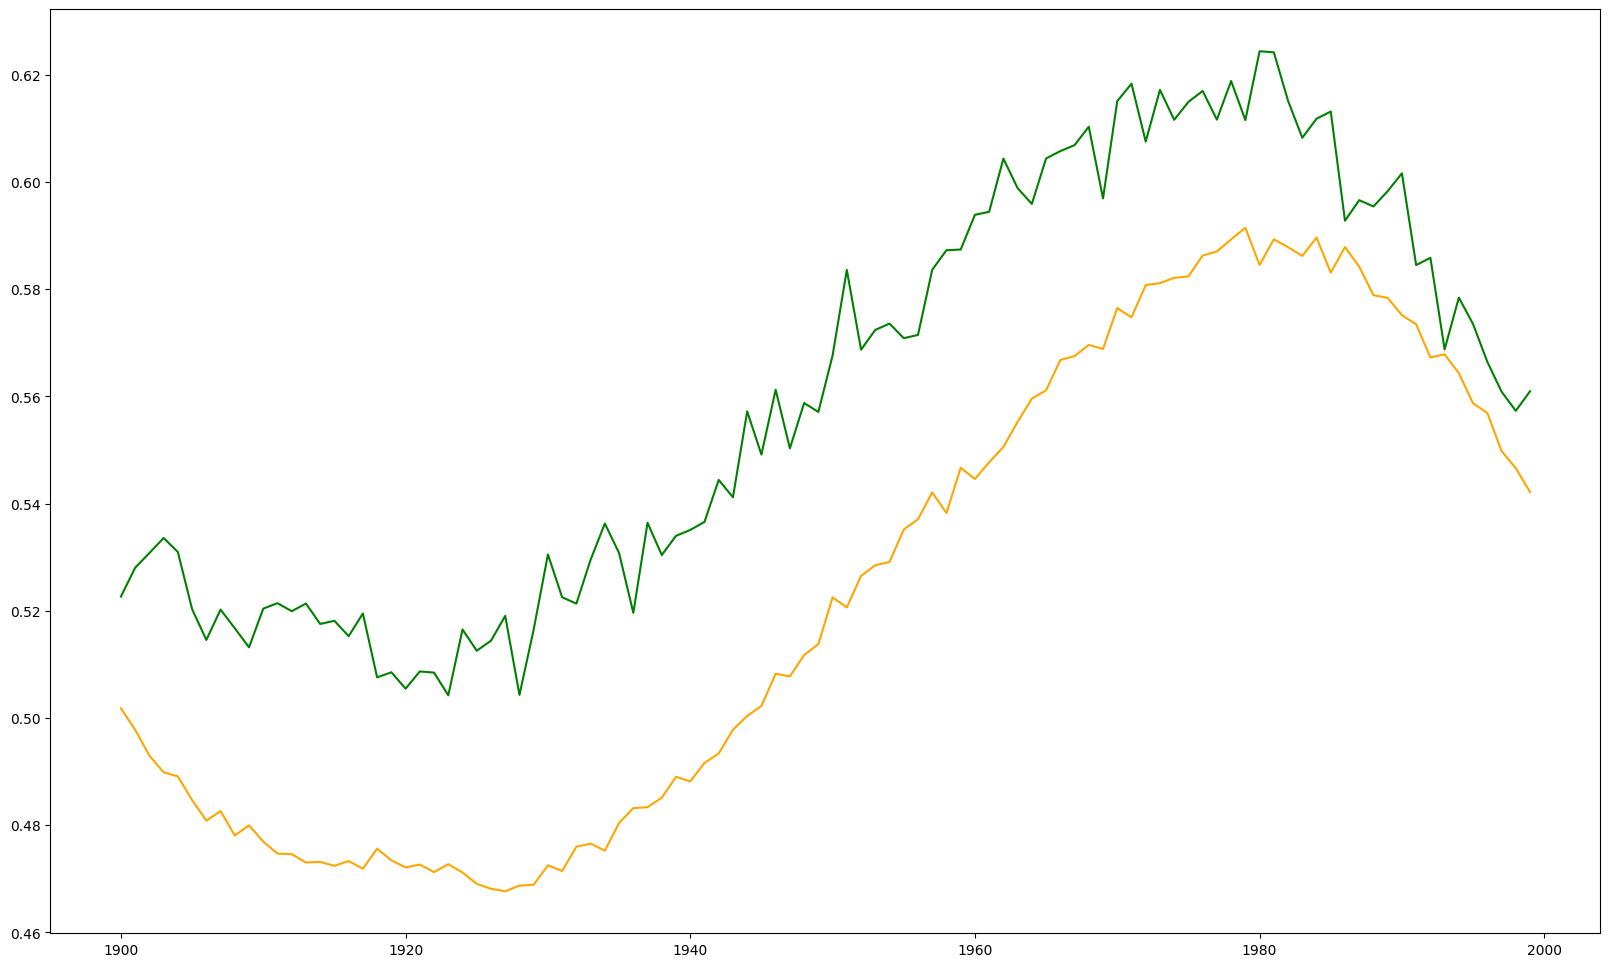

In [11]:
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange')
plt.show()

#### Costruzione architettura con LSTM e compilazione modello

In [12]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(step,1), return_sequences= True))
model_lstm.add(LSTM(units=64, return_sequences= True))
model_lstm.add(LSTM(units=64,))
model_lstm.add(Dense(32, activation = 'relu'))
model_lstm.add(Dense(32, activation = 'relu'))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer= Nadam(), metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 86113 (336.38 KB)
Trainable params: 8611

#### Addestramento del modello 

In [13]:
start = timer()
lstm_h = model_lstm.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
lstm_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 10s - loss: 0.2309 - mean_absolute_error: 0.4278 - 10s/epoch - 3s/step
Epoch 2/10
3/3 - 4s - loss: 0.1514 - mean_absolute_error: 0.3375 - 4s/epoch - 1s/step
Epoch 3/10
3/3 - 4s - loss: 0.0325 - mean_absolute_error: 0.1426 - 4s/epoch - 1s/step
Epoch 4/10
3/3 - 4s - loss: 0.0154 - mean_absolute_error: 0.1021 - 4s/epoch - 1s/step
Epoch 5/10
3/3 - 4s - loss: 0.0129 - mean_absolute_error: 0.0950 - 4s/epoch - 1s/step
Epoch 6/10
3/3 - 4s - loss: 0.0105 - mean_absolute_error: 0.0850 - 4s/epoch - 1s/step
Epoch 7/10
3/3 - 3s - loss: 0.0081 - mean_absolute_error: 0.0752 - 3s/epoch - 1s/step
Epoch 8/10
3/3 - 3s - loss: 0.0112 - mean_absolute_error: 0.0834 - 3s/epoch - 981ms/step
Epoch 9/10
3/3 - 3s - loss: 0.0105 - mean_absolute_error: 0.0824 - 3s/epoch - 974ms/step
Epoch 10/10
3/3 - 3s - loss: 0.0040 - mean_absolute_error: 0.0514 - 3s/epoch - 998ms/step
terminato.


#### Analisi de comportamento del modello con LSTM

In [14]:
train_predict_lstm = model_lstm.predict(train_x)
test_predict_lstm = model_lstm.predict(test_x)

10/10 [==============================] - 0s 48ms/step


#### Confronto comportamento del modello rispetto ai dati reali

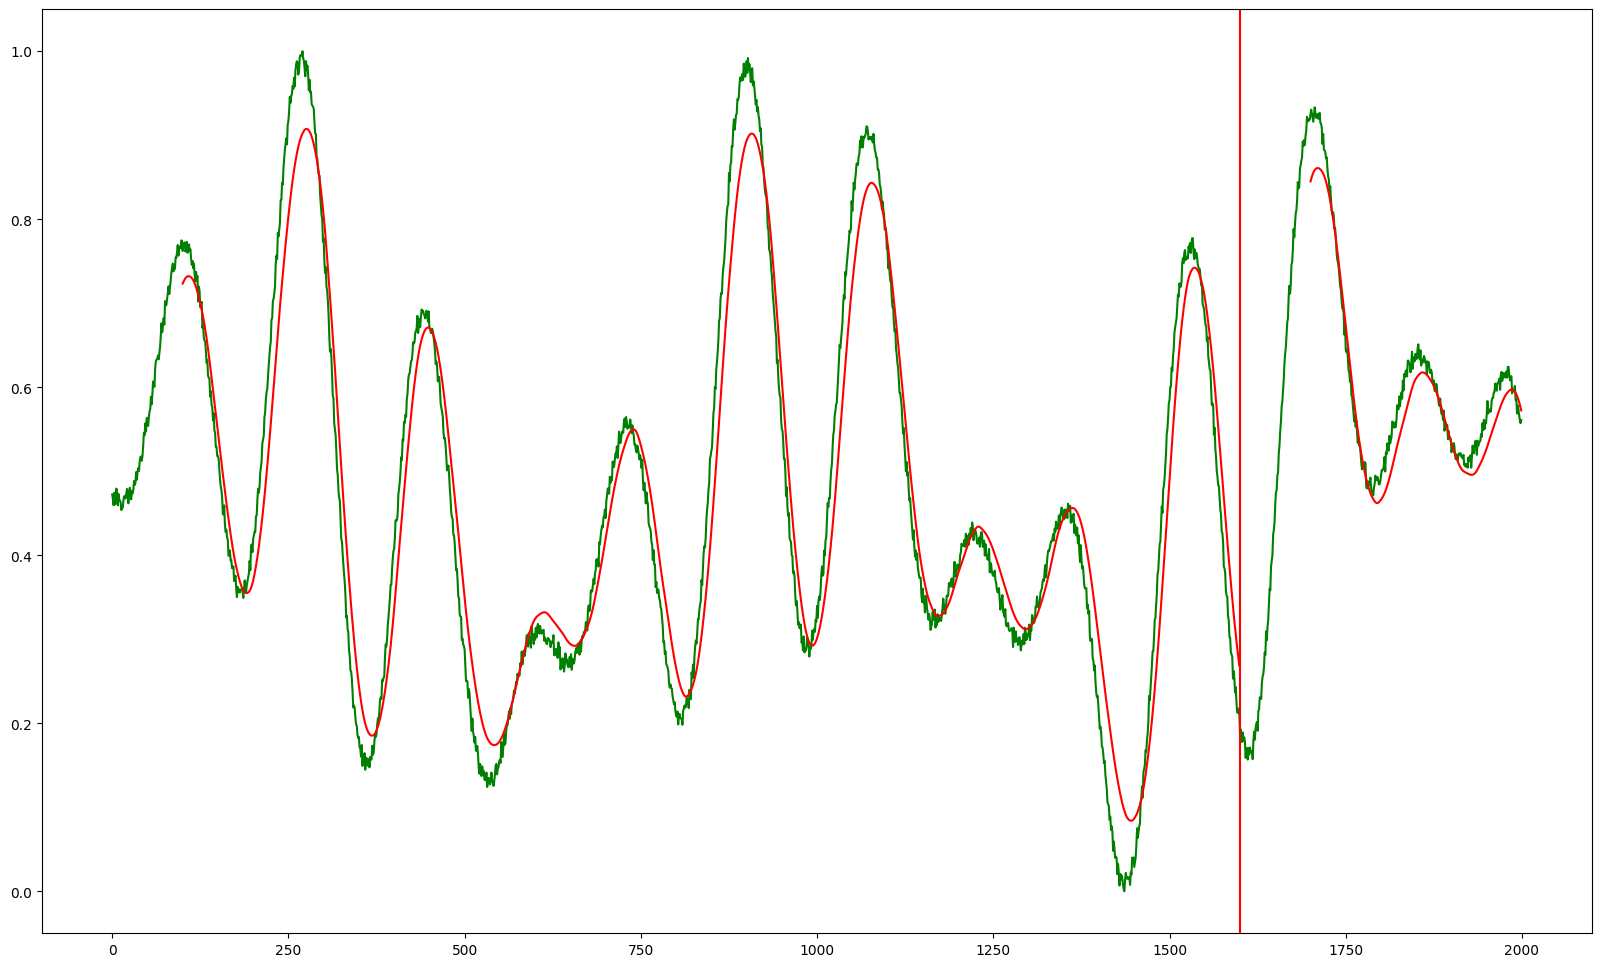

In [15]:
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_lstm) + step)]
plt.plot(x_train_preds, train_predict_lstm, color='red')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_lstm))]
plt.plot(x_test_preds, test_predict_lstm, color='red')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

#### Analisi degli ultimi 100 esempi sui dati reali 

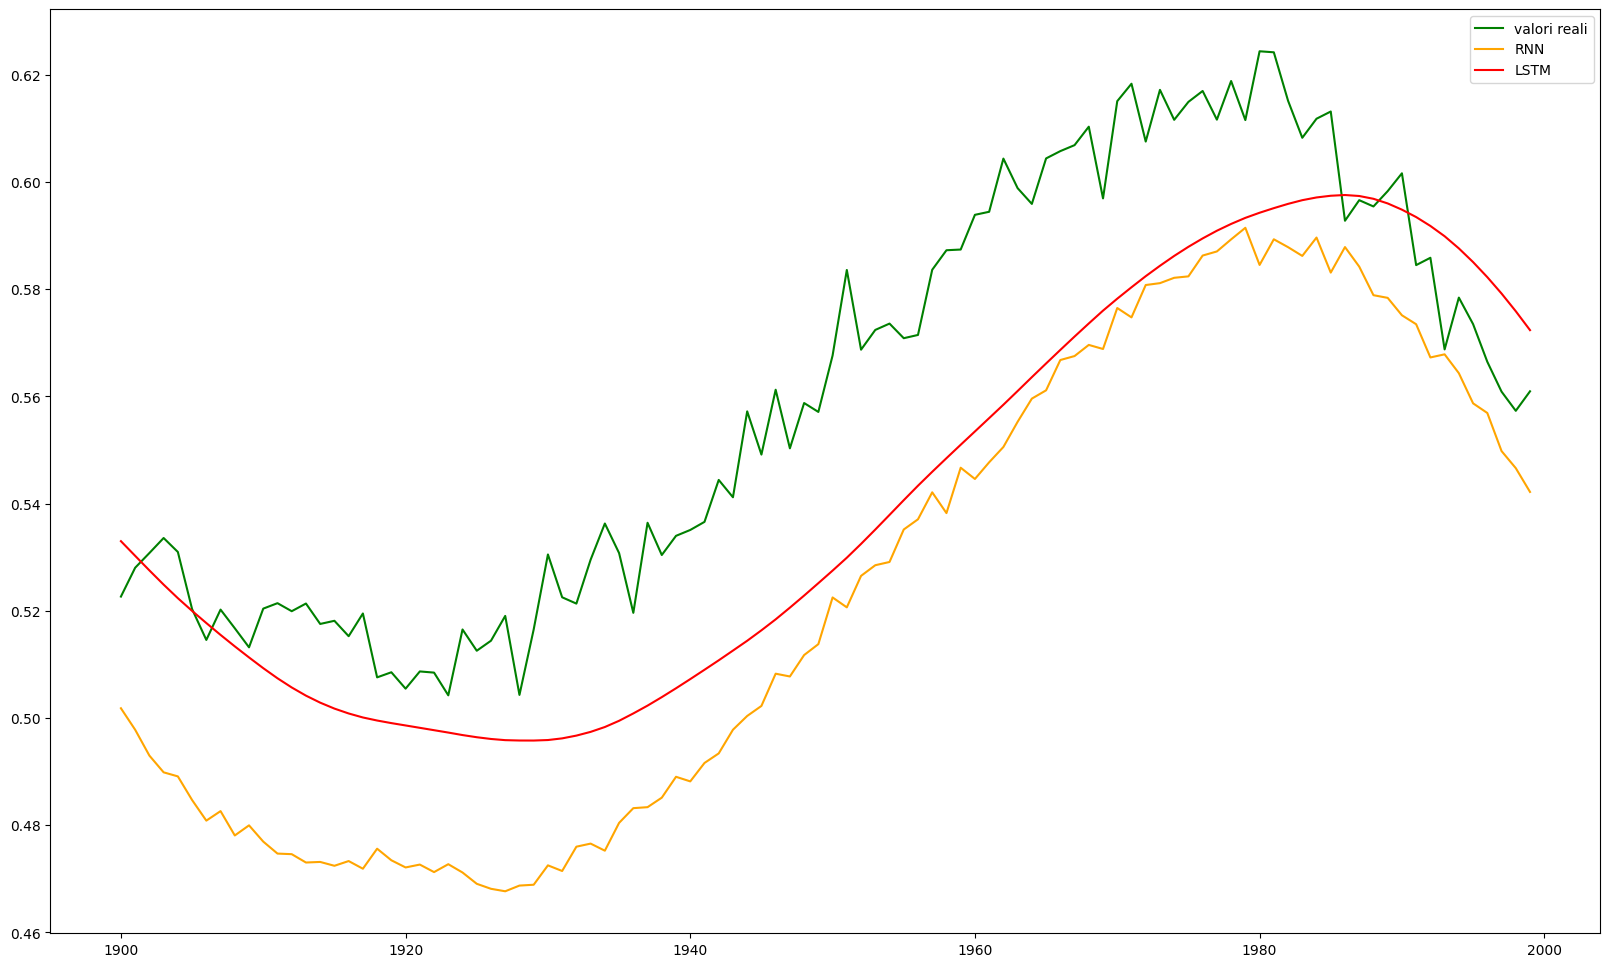

In [16]:
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green', label='valori reali')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.legend()
plt.show()

#### Creazione di un architettura basata su GRU e compilazione del modello 

In [17]:
model_gru = Sequential()
model_gru.add(GRU(units= 64, input_shape=(step, 1), return_sequences=True))
model_gru.add(GRU(units=64, return_sequences= True))
model_gru.add(GRU(units= 64))
model_gru.add(Dense(32, activation = 'relu'))
model_gru.add(Dense(32, activation = 'relu'))
model_gru.add(Dense(1))
model_gru.compile(loss= 'mean_squared_error', optimizer = Nadam(), metrics = ['mean_absolute_error'])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 64)           12864     
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 65953 (257.63 KB)
Trainable params: 6595

#### Addestramento

In [18]:
start = timer()
gru_h = model_gru.fit(train_x, train_y, epochs=10, batch_size= 512, verbose=2)
end = timer()
gru_t = end - start
print('terminato')

Epoch 1/10
3/3 - 9s - loss: 0.2607 - mean_absolute_error: 0.4557 - 9s/epoch - 3s/step
Epoch 2/10
3/3 - 3s - loss: 0.2157 - mean_absolute_error: 0.4113 - 3s/epoch - 976ms/step
Epoch 3/10
3/3 - 3s - loss: 0.1599 - mean_absolute_error: 0.3484 - 3s/epoch - 976ms/step
Epoch 4/10
3/3 - 3s - loss: 0.0851 - mean_absolute_error: 0.2407 - 3s/epoch - 943ms/step
Epoch 5/10
3/3 - 3s - loss: 0.0197 - mean_absolute_error: 0.1080 - 3s/epoch - 991ms/step
Epoch 6/10
3/3 - 3s - loss: 0.0142 - mean_absolute_error: 0.1048 - 3s/epoch - 975ms/step
Epoch 7/10
3/3 - 3s - loss: 0.0116 - mean_absolute_error: 0.0946 - 3s/epoch - 984ms/step
Epoch 8/10
3/3 - 3s - loss: 0.0090 - mean_absolute_error: 0.0828 - 3s/epoch - 1s/step
Epoch 9/10
3/3 - 4s - loss: 0.0078 - mean_absolute_error: 0.0757 - 4s/epoch - 1s/step
Epoch 10/10
3/3 - 4s - loss: 0.0067 - mean_absolute_error: 0.0700 - 4s/epoch - 1s/step
terminato


In [19]:
train_predict_gru = model_gru.predict(train_x)
test_predict_gru = model_gru.predict(test_x)

10/10 [==============================] - 0s 32ms/step


#### Confronto comportamento del modello rispetto ai dati reali

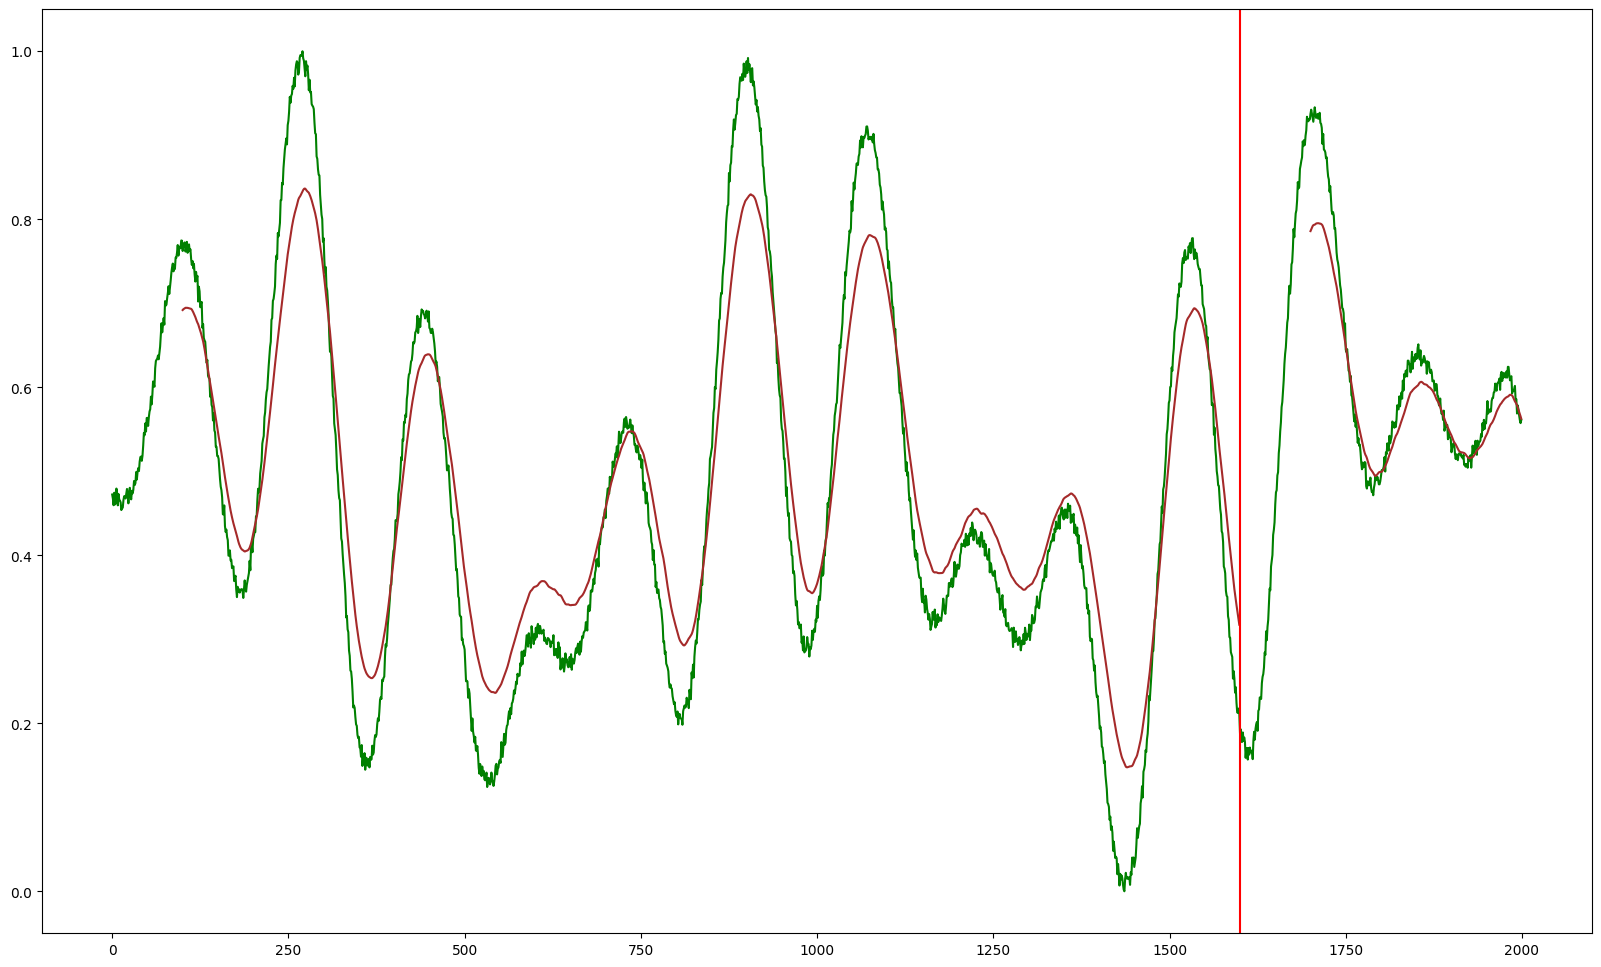

In [20]:
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [ x for x in range(step, len(train_predict_gru) + step)]
plt.plot(x_train_preds, train_predict_gru, color = 'brown')

x_test_preds = [test_split_point + x +step for x in range(0, len(test_predict_gru))]
plt.plot(x_test_preds, test_predict_gru, color = 'brown')

plt.axvline(df.index[test_split_point], c ='r')
plt.show()

#### Analisi degli ultimi 100 esempi sui dati reali 

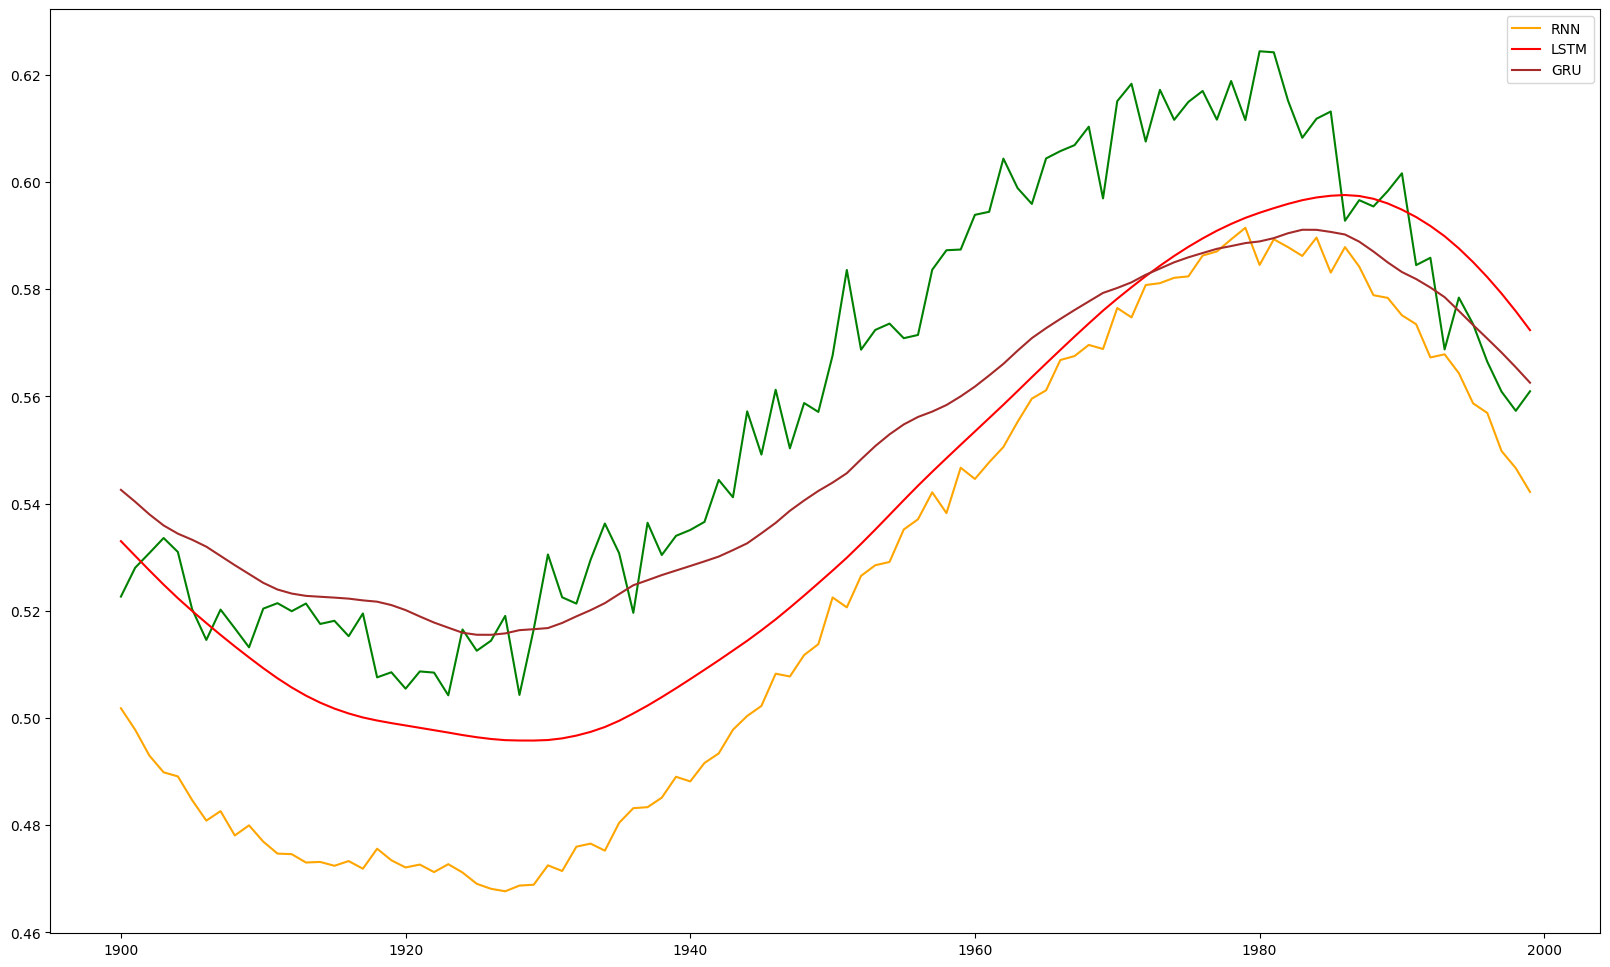

In [21]:
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:],test_predict_rnn[-100:], color= 'orange', label = 'RNN')
plt.plot(x_test_preds[-100:],test_predict_lstm[-100:], color= 'red', label = 'LSTM')
plt.plot(x_test_preds[-100:],test_predict_gru[-100:], color= 'brown', label = 'GRU')
plt.legend()
plt.show()

#### Illustrazione Loss dei 3 modelli

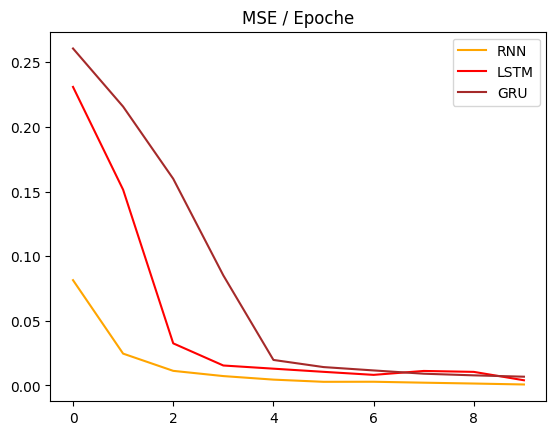

<Figure size 2000x1200 with 0 Axes>

In [22]:
f, ax = plt.subplots()
plt.figure(figsize=(20,12))
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.legend(['RNN', 'LSTM', 'GRU'], loc = 0)
plt.show() 

#### Illustrazione Acc dei 3 modelli

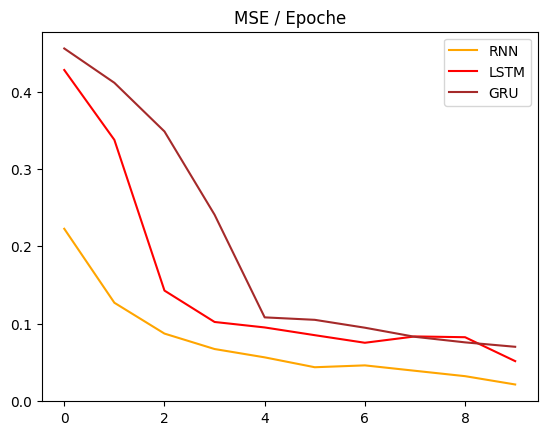

<Figure size 2000x1200 with 0 Axes>

In [23]:
f, ax = plt.subplots()
plt.figure(figsize=(20,12))
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.legend(['RNN', 'LSTM', 'GRU'], loc = 0)
plt.show() 

#### Implementazione di un modello di base di rete ricorrente 

In [24]:
model_vanilla = Sequential()
model_vanilla.add(SimpleRNN(units = 64, input_shape= (step, 1), activation = 'relu'))
model_vanilla.add(Dense(32, activation = 'relu'))
model_vanilla.add(Dense(1))
model_vanilla.compile(loss='mean_squared_error', optimizer = Nadam(), metrics= ['mean_absolute_error'])
model_vanilla.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Addestramento

In [25]:
start = timer()
vanilla_h = model_vanilla.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
vanilla_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 2s - loss: 0.1500 - mean_absolute_error: 0.3448 - 2s/epoch - 527ms/step
Epoch 2/10
3/3 - 0s - loss: 0.0998 - mean_absolute_error: 0.2779 - 136ms/epoch - 45ms/step
Epoch 3/10
3/3 - 0s - loss: 0.0526 - mean_absolute_error: 0.1930 - 144ms/epoch - 48ms/step
Epoch 4/10
3/3 - 0s - loss: 0.0103 - mean_absolute_error: 0.0735 - 148ms/epoch - 49ms/step
Epoch 5/10
3/3 - 0s - loss: 0.0011 - mean_absolute_error: 0.0288 - 151ms/epoch - 50ms/step
Epoch 6/10
3/3 - 0s - loss: 4.0116e-04 - mean_absolute_error: 0.0166 - 154ms/epoch - 51ms/step
Epoch 7/10
3/3 - 0s - loss: 3.7256e-04 - mean_absolute_error: 0.0153 - 152ms/epoch - 51ms/step
Epoch 8/10
3/3 - 0s - loss: 5.6272e-04 - mean_absolute_error: 0.0193 - 155ms/epoch - 52ms/step
Epoch 9/10
3/3 - 0s - loss: 8.7048e-05 - mean_absolute_error: 0.0076 - 151ms/epoch - 50ms/step
Epoch 10/10
3/3 - 0s - loss: 8.7534e-05 - mean_absolute_error: 0.0076 - 156ms/epoch - 52ms/step
terminato.


In [26]:
train_predict_vanilla = model_vanilla.predict(train_x)
test_predict_vanilla = model_vanilla.predict(test_x)

10/10 [==============================] - 0s 5ms/step


#### Analisi degli ultimi 100 esempi sui dati reali 

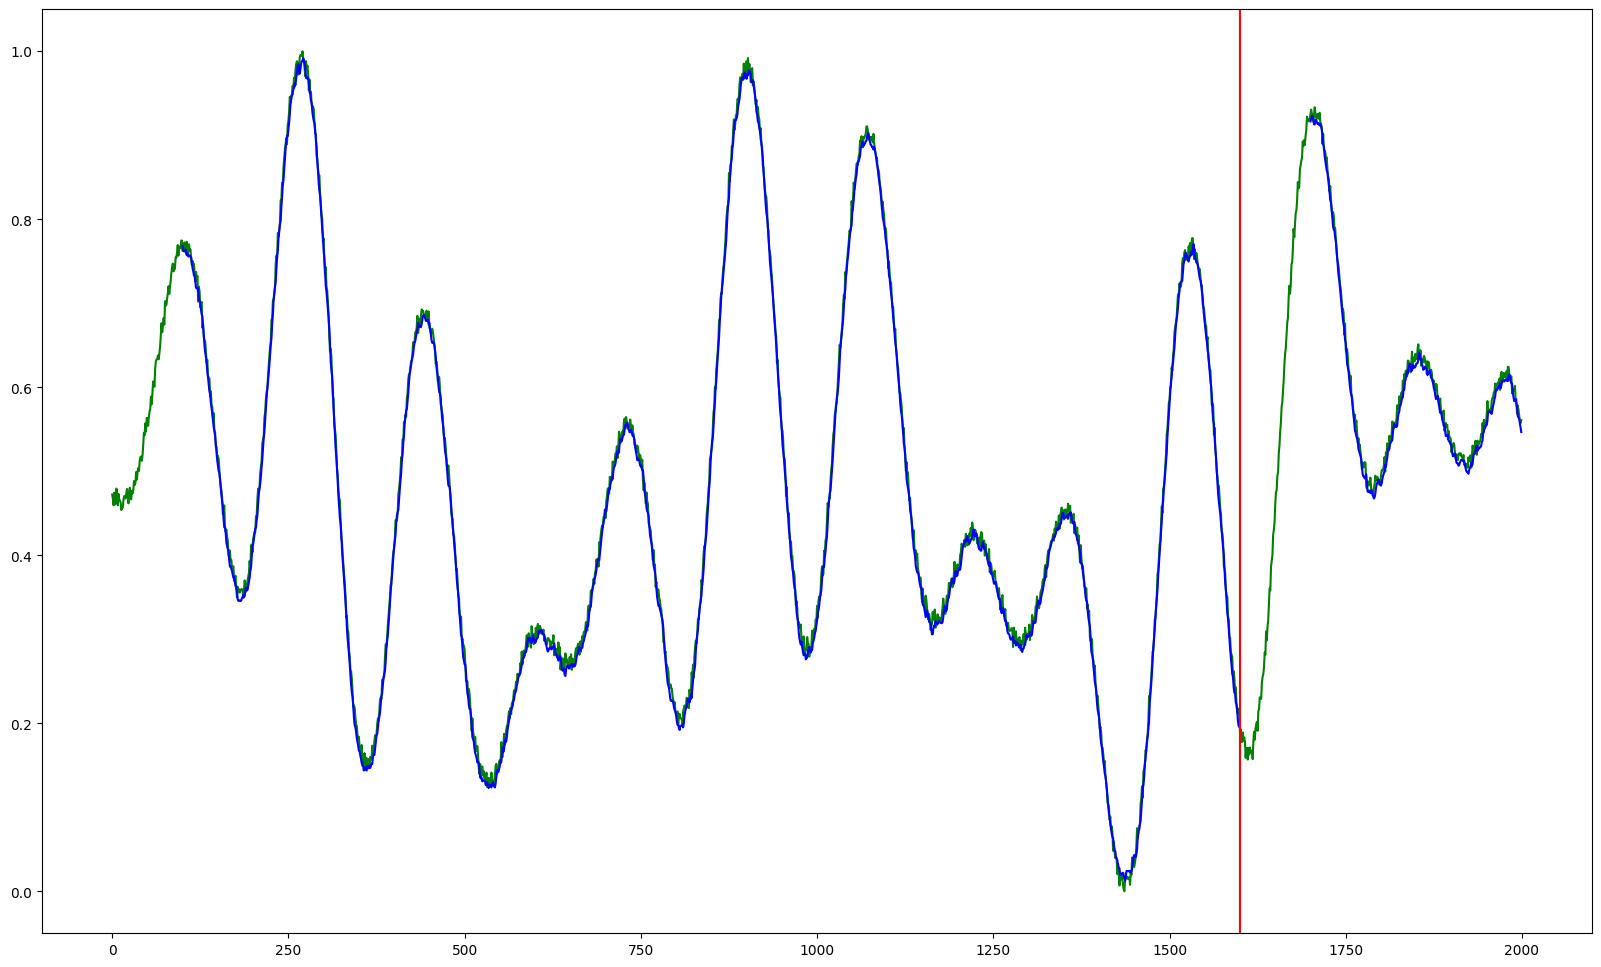

In [27]:
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_vanilla) + step)]
plt.plot(x_train_preds, train_predict_vanilla, color='blue')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_vanilla))]
plt.plot(x_test_preds, test_predict_vanilla, color='blue')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

#### Confronto comportamento del modello rispetto ai dati reali

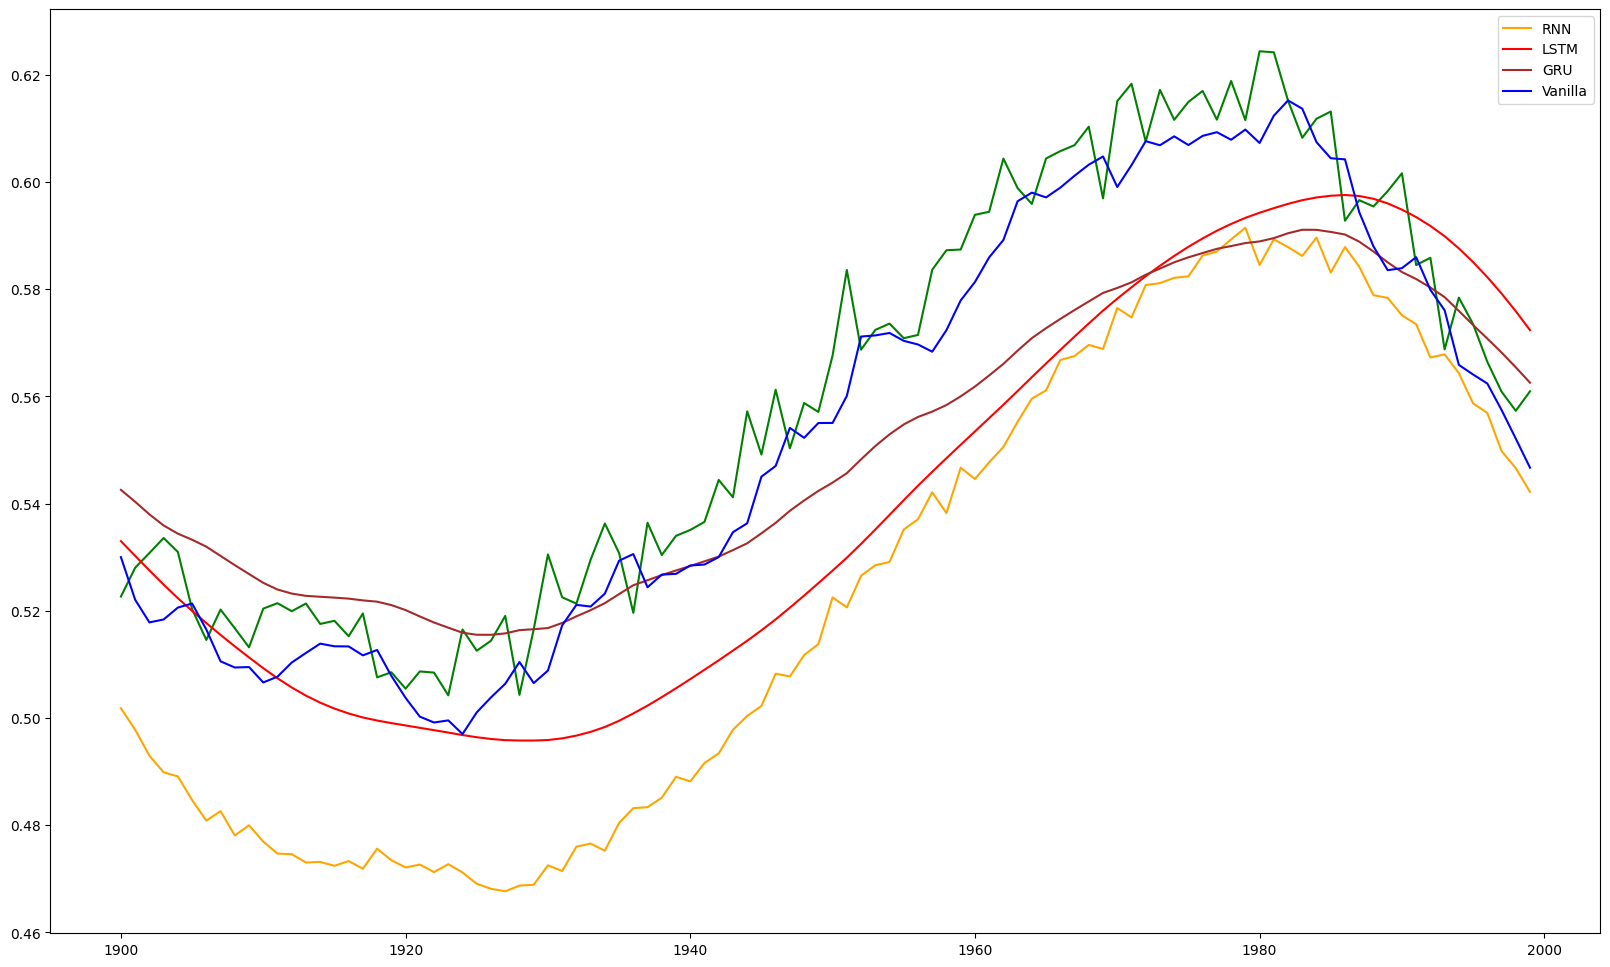

In [28]:
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

#### Illustrazione Loss dei 3 modelli

<Figure size 2000x1200 with 0 Axes>

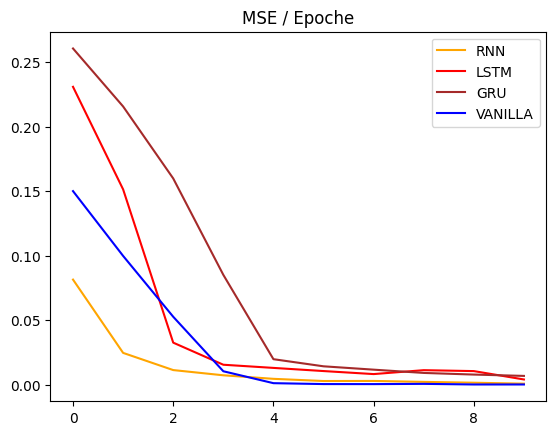

In [29]:
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.plot(vanilla_h.history['loss'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

#### Illustrazione Acc dei 3 modelli

<Figure size 2000x1200 with 0 Axes>

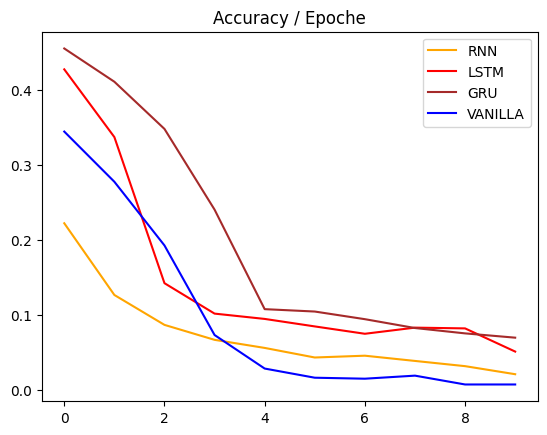

In [30]:
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.plot(vanilla_h.history['mean_absolute_error'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

In [31]:
print('          loss      mae     time')
print('LSTM    ', str(lstm_h.history['loss'][len(lstm_h.history['loss'])-1])[:5], '  ', str(lstm_h.history['mean_absolute_error'][len(lstm_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(lstm_t)[:5])
print('GRU     ', str(gru_h.history['loss'][len(gru_h.history['loss'])-1])[:5], '  ', str(gru_h.history['mean_absolute_error'][len(gru_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(gru_t)[:5])
print('RNN     ', str(rnn_h.history['loss'][len(rnn_h.history['loss'])-1])[:5], '  ', str(rnn_h.history['mean_absolute_error'][len(rnn_h.history['mean_absolute_error'])-1])[:5],
      '    ' + str(rnn_t)[:4])
print('VANILLA ', str(vanilla_h.history['loss'][len(vanilla_h.history['loss'])-1])[:5], '  ', 
      str(vanilla_h.history['mean_absolute_error'][len(vanilla_h.history['mean_absolute_error'])-1])[:5], '    ' + str(vanilla_t)[:4])

          loss      mae     time
LSTM     0.003    0.051    42.43
GRU      0.006    0.069    37.02
RNN      0.000    0.021     11.0
VANILLA  8.753    0.007     3.00
